# Revert to PorePy setup directly

To better understand potential errors in scaling, we revert to the PorePy setup for scaling by subclassing `ContactMechanicsBiot` with basic and transparent parameter setup. Then, we will gradually make the model more complex, hopefully finding out where `ContactMechanicsBiotISC` breaks.

In [2]:
import os
import sys
from pathlib import Path

import pendulum
import numpy as np
import porepy as pp
from porepy.models.contact_mechanics_biot_model import ContactMechanicsBiot

import logging
logging.basicConfig(level='INFO')

/home/haakon/porepy/src/porepy/viz/exporter.py:928: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  angle = np.arccos(np.dot(normals[:, fi], reference))


In [3]:
_ROOT = '~/mastersproject/src/mastersproject/GTS/test'

In [4]:
class SimpleContactMechanicsBiot(ContactMechanicsBiot):
    def __init__(self, params):
        """ 
        
        params needs the following keywords
            length_scale, scalar_scale : float
        """
        
        # Back-end
        _root = _ROOT
        name = "test_parameter_scaling_basic_setup_on_regular_grid_ipynb"
        date = pendulum.now().format("YYMMDD")
        _f = f"{name}/{date}/test_1"
        path_head = f"{_f}/ss{params['scalar_scale']}ls{params['length_scale']}"
        _results_path = f"{_root}/results/{_root}"
        Path(_results_path).mkdir(parents=True, exist_ok=True)
        params["folder_name"] = _results_path
        
        super().__init__(params)
        
        # Time parameters
        self.time = 0
        self.time_step = 1 * pp.HOUR
        self.end_time = 1 * pp.HOUR
        
        
        self.file_name = 'main_run'
        
        # -- Physical parameters --
        # STRESS
        # Create a simple stress tensor, rotated by 45 degrees (to induce slip)
        stress = - np.array([  # Anisotropic stress (negative for compressive)
            [0.5, 0, 0],
            [0, 1.5, 0],
            [0, 0, 1.0]
        ]) # Unscaled stress. Units: [Pa]
        a = np.pi / 4  # Rotate the stress 45 degrees
        vec = np.array([0, 0, 1]) # about the unit vector e_z.
        R = pp.geometry.map_geometry.rotation_matrix(a, vec)
        self.stress = R.dot(stress.dot(R.T)) # Stress in the rotated frame.
        
    def create_grid(self):
        # Size of domain - scaled by length scale.
        physdims = np.array([10, 10, 10]) * pp.METER / self.length_scale
        bounding_box = {
            "xmin": -10, "xmax": physdims[0], # TEMP: A1: double
            "ymin": -10, "ymax": physdims[1], # TEMP: A1: double
            "zmin": -10, "zmax": physdims[2], # TEMP: A1: double
        }
        self.box = bounding_box
        
        f_1 = np.array([
            [5, 5, 5, 5],
            [0, 0, 5, 5],
            [0, 5, 5, 0]
        ]) * pp.METER / self.length_scale
        
        # Number of cells in each dimension.
        n_cells = np.array([2, 2, 2]) * 2 # TEST: A1: double
        
        gb = pp.meshing.cart_grid(
            fracs=[f_1],
            nx=n_cells,
            physdims=physdims,
        )
        self.gb = gb
        pp.contact_conditions.set_projections(self.gb)
        self.Nd = gb.dim_max()
        self.n_frac = gb.get_grids(lambda _g: _g.dim == self.Nd - 1).size
        
    def bc_values_mechanics(self, g):
        """ Set top and sides to neumann stress tensor.
        Clamp the bottom to zero dirichlet
        """
        
        # Retrieve the domain boundary
        all_bf, east, west, north, south, top, bottom = self.domain_boundary_sides(g)
        dim = g.dim

        # Boundary values
        bc_values = np.zeros((g.dim, g.num_faces))

        # --- mechanical state ---
        # Get outward facing normal vectors for domain boundary, weighted for face area

        # 1. Get normal vectors on the faces. These are already weighed by face area.
        bf_normals = g.face_normals * pp.METER**(dim-1)
        # 2. Adjust direction so they face outwards
        flip_normal_to_outwards = np.where(g.cell_face_as_dense()[0, :] >= 0, 1, -1)
        outward_normals = bf_normals * flip_normal_to_outwards
        bf_stress = np.dot(self.stress, outward_normals[:, all_bf])
        # Units [P L^(dim-1)] -- g.face_normals is scaled. Now, scale pressure:
        bc_values[:, all_bf] += bf_stress * pp.PASCAL / self.scalar_scale  # Mechanical stress
        
        # Dirichlet
        # Units: [L]
        bc_values[:, bottom] = 0 * pp.METER  # / self.length_scale
        
        return bc_values.ravel("F")
    
    def bc_type_mechanics(self, g):
        """ Neumann eveywhere except bottom face, where it is Dirichlet"""
        all_bf, east, west, north, south, top, bottom = self.domain_boundary_sides(g)
        bc = pp.BoundaryConditionVectorial(g, bottom, "dir")
        fracture_faces = g.tags["fracture_faces"]
        bc.is_neu[:, fracture_faces] = False
        bc.is_dir[:, fracture_faces] = True
        
        return bc
    
    def bc_values_scalar(self, g):
        """ Dirichlet everywhere. Fluid injection on west face"""
        all_bf, east, west, north, south, top, bottom = self.domain_boundary_sides(g)
        
        bc_values = np.zeros(g.num_faces)
        
        pressure_at_west = 5 * pp.PASCAL / self.scalar_scale
        bc_values[west] = pressure_at_west
        
        return bc_values
        
    def bc_type_scalar(self, g):
        """ Dirichlet everywhere"""
        all_bf, *_ = self.domain_boundary_sides(g)
        # Define boundary condition on faces
        return pp.BoundaryCondition(g, all_bf, ["dir"] * all_bf.size)
    
    def source_scalar(self, g):
        source = np.zeros(g.num_cells)
#         if g.dim == self.Nd-1:  # in a fracture

        # Set in-flow in fracture and on grid.
        flow_rate = 10 * pp.MILLI * (pp.METER / self.length_scale) ** self.Nd
        source[0] += flow_rate * self.time_step
        
        return source
    
    def source_mechanics(self, g):
        return np.zeros(self.Nd * g.num_cells)
    
    def _set_friction_coefficient(self, g):
        return np.ones(g.num_cells) * 0.5
    
    def compute_aperture(self, g):
        apertures = np.ones(g.num_cells)
        if g.dim < self.Nd:
            apertures *= 0.1
        return apertures
    
    def biot_alpha(self, g):
        return 1
    
    
    

# Check scaling of parameters and solution

In [5]:
def check_parameter_scaling(s1, s2, dim):
    """ Test parameter scaling for two setups"""
    print(f"Checking parameters for two setups on grid of dimension: {dim}")
    
    def fetch_values_from_setup(s, dim):
        # scales
        ls = s.length_scale
        ss = s.scalar_scale
        # grids
        gb = s.gb
        g = gb.grids_of_dimension(dim)[0]
        # data
        data = gb.node_props(g)
        params_u = data['parameters']['mechanics']
        params_p = data['parameters']['flow']
        
        neu_p = params_p['bc'].is_neu
        dir_p = params_p['bc'].is_dir
        
        # Compute unscaled quantities: 
        # MECHANICS
        if dim == s.Nd: # On rock matrix
            neu_u = (params_u['bc'].is_neu).ravel(order='F')
            dir_u = (params_u['bc'].is_dir).ravel(order='F')
            mech = {
                'bc_values': {
                    'dir': params_u['bc_values'][dir_u].reshape((3, -1), order='F') * ls, # [L]
                    'neu': params_u['bc_values'][neu_u].reshape((3, -1), order='F') * ss * ls**(dim-1), # [P L^(dim-1)]
                },
                'source':
                    params_u['source'] * ss * ls**(dim-1), # [P L^(dim-1)]
                'biot_alpha': # [ ]
                    params_u['biot_alpha'], 
                'mu':
                    params_u['fourth_order_tensor'].mu * ss, # [P]
                'lambda':
                    params_u['fourth_order_tensor'].lmbda * ss, # [P]
            }
        elif dim == s.Nd-1: # On fracture
            mech = params_u # We're only interested in the friction coefficient
        
        # FLOW
        flow = {
            'bc_values': {
                'dir': params_p['bc_values'][dir_p] * ss, # [P]
                'neu': params_p['bc_values'][neu_p] * ls**dim, # [L^(dim)]
            },
            'mass_weight':  
                params_p['mass_weight'] / ss,  # [1/P]
            'source':
                params_p['source'] * ls**dim, # [L^(dim)]
            'biot_alpha': # [ ]
                params_p['biot_alpha'],
            'kxx':
                params_p['second_order_tensor'].values[0, 0, :] * ls**2 / ss, #k/mu: [L^2 / P]
        }
        return mech, flow
    
    mech1, flow1 = fetch_values_from_setup(s1, dim)
    mech2, flow2 = fetch_values_from_setup(s2, dim)
    
    # -- ASSERTIONS --
    # Mechanics
    if dim == s1.Nd:
        # BC:
        assert np.allclose(mech1['bc_values']['dir'], mech2['bc_values']['dir'])
        assert np.allclose(mech1['bc_values']['neu'], mech2['bc_values']['neu'])
        # Source
        assert np.allclose(mech1['source'], mech2['source'])
        # Physical parameters
        assert np.allclose(mech1['biot_alpha'], mech2['biot_alpha'])
        assert np.allclose(mech1['mu'], mech2['mu'])
        assert np.allclose(mech1['lambda'], mech2['lambda'])
    elif dim == s1.Nd-1:
        assert np.allclose(mech1['friction_coefficient'], mech2['friction_coefficient'])
    
    # Flow
    # BC:
    assert np.allclose(flow1['bc_values']['dir'], flow2['bc_values']['dir'])
    assert np.allclose(flow1['bc_values']['neu'], flow2['bc_values']['neu'])
    # Source
    assert np.allclose(flow1['source'], flow2['source'])
    # Physical parameters
    assert np.allclose(flow1['biot_alpha'], flow2['biot_alpha'])
    assert np.allclose(flow1['kxx'], flow2['kxx'])
    
def check_mortar_parameter_scaling(s1, s2):
    def fetch_values_from_setup(s, dim):
        # scales
        ls = s.length_scale
        ss = s.scalar_scale
        # grids
        gb = s.gb
        
        for e, d in gb.edges():
            k = d['parameters']['flow']['normal_diffusivity']

In [6]:
def assert_solutions(s1, s2, dim):
    """ Assert that solutions scale correctly
    
    Parameters
    ----------
    s1, s2 : ContactMechanicsBiotISC
        Setups
    dim : int
        which grid dimension to extract solutions over
    """
    print(f"Checking solutions for two setups on grid of dimension: {dim}")
    
    def fetch_values_from_setup(s, dim):
        # scales
        ls = s.length_scale
        ss = s.scalar_scale
        # grids
        gb = s.gb
        g = gb.grids_of_dimension(dim)[0]
        # data
        d = gb.node_props(g)
        state = d[pp.STATE]
        
        ### Quantities ###
        cell_centers = g.cell_centers * ls
        cell_volumes = g.cell_volumes * (ls)**dim
        face_areas = g.face_areas * (ls)**(dim-1)
        p = state['p'] * ss
        
        Nd = s.Nd
        # Matrix displacement
        if dim == Nd:
            u = state['u'] * ls
            
            # These are in reality only fetched on fracture. 
            # Set to 0 if 3d-matrix is checked.
            tangential_traction = [0]
            normal_traction = [0]
            u_t_norm = [0]
            u_n = [0]
        elif dim == Nd - 1:
            # Fetch the mortar grid and data
            e, de = [i for i in gb.edges()][0]
            
            # Displacement (global coords)
            mg = d_e['mortar_grid']
            mortar_u = d_e['state']['mortar_u']
            u = (mg.mortar_to_slave_avg(nd=Nd) 
                 * mg.sign_of_mortar_sides(nd=Nd)
                 * mortar_u) * ls
            
            # Displacement (local coords)
            u_local = s.reconstruct_local_displacement_jump(de, from_iterate=False) *ls
            u_t_norm = np.norm(u_local[:2, :], axis=0)
            u_n = u_local[2, :]
            
            # Traction
            # recall: traction is represented in local coordinates directly.
            proj = d_e['tangential_normal_projection']
            proj.tangential_basis[:,:,0]
            traction = d['state']['contact_traction']
            tangential_traction_local = traction[:-1]
            normal_traction = traction[-1]
            tangential_traction = proj.tangential_basis[:,:,0].dot(tangential_traction_local)
            # upscale the scaled result
            normal_traction = normal_traction * ss * ls**(Nd-1)
            tangential_traction = tangential_traction * ss * ls**(Nd-1)

        
        return (cell_centers, cell_volumes, face_areas, p, u, 
                normal_traction, tangential_traction, u_t_norm, u_n)
    
    # Get the results
    (cell_centers1, cell_volumes1, face_areas1, p1, u1, 
     normal_traction1, tangential_traction1, u_t_norm1, u_n1
    ) = fetch_values_from_setup(s1, dim)
    
    (cell_centers2, cell_volumes2, face_areas2, p2, u2, 
     normal_traction2, tangential_traction2, u_t_norm2, u_n2
    ) = fetch_values_from_setup(s2, dim)

    ### Assertions ###
    # Assert that each geometric index corresponds to one another
    assert np.allclose(cell_centers1, cell_centers2)
    
    # Assert that all volumes and areas are the same
    assert np.allclose(cell_volumes1, cell_volumes2)
    assert np.allclose(face_areas1, face_areas2)
    
    ## Non-zero on all grids ##
    # Assert that the pressure results are equal
    p_true = np.allclose(p1, p2)
#     assert p_true
    print(f"p: {p_true}")
    
    # Assert that the displacement results are equal
    u_true = np.allclose(u1, u2)
#     assert u_true
    print(f"u: {u_true}")
    
    # Assert that norm of tangential displacement is equal
    u_t_norm_true = np.allclose(u_t_norm1, u_t_norm2)
    print(f"norm of u_n: {u_t_norm_true}")
    # Assert that norm displacement is equal
    u_n_true = np.allclose(u_n1, u_n2)
    print(f"u_n: {u_n_true}")


    # Traction
    n_traction_true = np.allclose(normal_traction1, normal_traction2)
#     assert n_traction_true
    print(f"normal_traction: {n_traction_true}")
    t_traction_true = np.allclose(tangential_traction1, tangential_traction2)
#     assert t_traction_true
    print(f"tangential_traction: {t_traction_true}")
    
    assert (p_true and p_exp_true and u_true and n_traction_true and t_traction_true
            and u_t_norm_true and u_n_true
           )

## Unscaled setup

In [8]:
un = SimpleContactMechanicsBiot(params)

In [9]:
un.create_grid()

INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 14 intersections. Ellapsed time: 0.01446
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00057
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 56 points, 42
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. Ellapsed time
                    0.01761
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.fracs.fractures:Done with intersection removal. Elapsed time 0.03618
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 12 points, 17
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 17 edges. Ellapsed time
                    0.00949
INFO:porepy.fracs.fractures:Finished fracture splitting after 0.07703 seconds
INFO:porepy.fracs.meshing:Asse

In [13]:
gb = un.gb
g = gb.grids_of_dimension(3)[0]
f = gb.grids_of_dimension(2)[0]

ValueError: operands could not be broadcast together with shapes (3,4) (3,) 

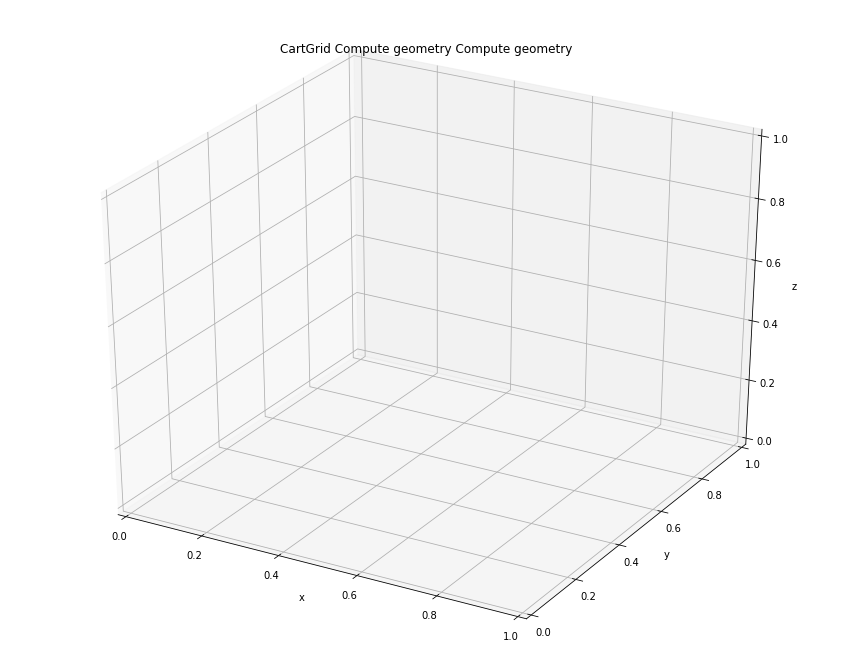

In [17]:
pp.plot_grid(g, info="all", alpha=0, figsize=(15, 12))

In [ ]:
%debug

> /home/haakon/porepy/src/porepy/utils/sort_points.py(114)sort_point_plane()
    112     R = pp.map_geometry.project_plane_matrix(pts, normal)
    113     # project points and center,  project to plane
--> 114     delta = np.dot(R, pts - centre)
    115 
    116     # Find active dimension in the projected system

ipdb> u
> /home/haakon/porepy/src/porepy/viz/plot_grid.py(534)plot_grid_3d()
    532             ptsId = nodes_faces[loc_f]
    533             mask = pp.utils.sort_points.sort_point_plane(
--> 534                 g.nodes[:, ptsId], g.face_centers[:, f], g.face_normals[:, f]
    535             )
    536             pts = g.nodes[:, ptsId[mask]]

ipdb> ll
    510 def plot_grid_3d(g, ax, **kwargs):
    511     """
    512     Plot the 3d grid g to the axis ax.
    513     """
    514     faces_cells, cells, _ = sps.find(g.cell_faces)
    515     nodes_faces, faces, _ = sps.find(g.face_nodes)
    516 
    517     cell_value = np.zeros(g.num_cells)
    518     rgb = kwargs.get("

ipdb> u
> /home/haakon/porepy/src/porepy/viz/plot_grid.py(534)plot_grid_3d()
    532             ptsId = nodes_faces[loc_f]
    533             mask = pp.utils.sort_points.sort_point_plane(
--> 534                 g.nodes[:, ptsId], g.face_centers[:, f], g.face_normals[:, f]
    535             )
    536             pts = g.nodes[:, ptsId[mask]]

ipdb> g.nodes[:, ptsId]
array([[0. , 0. , 0. , 0. ],
       [0. , 2.5, 0. , 2.5],
       [0. , 0. , 2.5, 2.5]])
ipdb> g.face_centers[:, f]
array([0.  , 1.25, 1.25])
ipdb> g.face_normals[:, f]
array([6.25, 0.  , 0.  ])
ipdb> np.atleast_2d(g.face_normals[:, f])
array([[6.25, 0.  , 0.  ]])
ipdb> np.atleast_2d(g.face_normals[:, f]).T
array([[6.25],
       [0.  ],
       [0.  ]])
ipdb> d
> /home/haakon/porepy/src/porepy/utils/sort_points.py(114)sort_point_plane()
    112     R = pp.map_geometry.project_plane_matrix(pts, normal)
    113     # project points and center,  project to plane
--> 114     delta = np.dot(R, pts - centre)
    115 
    116   

In [7]:
params={
    "length_scale": 1,
    "scalar_scale": 1,
}

un = SimpleContactMechanicsBiot(params)
pp.run_time_dependent_model(un, {})

INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 14 intersections. Ellapsed time: 0.01498
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00074
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 56 points, 42
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. Ellapsed time
                    0.01483
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.fracs.fractures:Done with intersection removal. Elapsed time 0.03628
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 12 points, 17
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 17 edges. Ellapsed time
                    0.01117
INFO:porepy.fracs.fractures:Finished fracture splitting after 0.07644 seconds
INFO:porepy.fracs.meshing:Asse

INFO:porepy.models.contact_mechanics_model:Error in matrix displacement is 1.009576335700648


ValueError: Newton iterations did not converge

# Scale by length

In [128]:
params={
    "length_scale": 10,
    "scalar_scale": 1,
}

ls10 = SimpleContactMechanicsBiot(params)
pp.run_time_dependent_model(ls10, {})

INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 14 intersections. Ellapsed time: 0.01483
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00052
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 56 points, 42
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. Ellapsed time
                    0.01273
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.fracs.fractures:Done with intersection removal. Elapsed time 0.03540
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 12 points, 17
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 17 edges. Ellapsed time
                    0.00978
INFO:porepy.fracs.fractures:Finished fracture splitting after 0.07360 seconds
INFO:porepy.fracs.meshing:Asse

# Check scaling of parameters and solutions

In [105]:
check_mortar_parameter_scaling(un, ls10)

In [106]:
check_parameter_scaling(un, ls10, 3)

check_parameter_scaling(un, ls10, 2)

In [123]:
print(3)
assert_solutions(un, ls10, 3)

print(2)
assert_solutions(un, ls10, 2)

3
p: False
u: False
norm of u_n: True
u_n: True
normal_traction: True
tangential_traction: True


AssertionError: 

In [124]:
%debug

> <ipython-input-121-7af51e21fd1f>(113)assert_solutions()
    110     print(f"tangential_traction: {t_traction_true}")
    111 
    112     assert (p_true and p_exp_true and u_true and n_traction_true and t_traction_true
--> 113             and u_t_norm_true and u_n_true
    114            )

ipdb> p1
array([1.45459663, 0.20128027, 1.45599588, 0.20718681, 1.45591724,
       0.20710498, 1.45611978, 0.20771323])
ipdb> p2
array([1.44496451, 0.15273147, 1.45423369, 0.20145324, 1.45415263,
       0.20137351, 1.45558053, 0.20638157])
ipdb> p1-p2
array([0.00963212, 0.04854879, 0.00176219, 0.00573357, 0.00176461,
       0.00573147, 0.00053925, 0.00133166])
ipdb> (p1-p2)/p2
array([0.00666599, 0.31787025, 0.00121177, 0.02846104, 0.0012135 ,
       0.02846188, 0.00037047, 0.0064524 ])
ipdb> cell_centers1
array([[2.5, 7.5, 2.5, 7.5, 2.5, 7.5, 2.5, 7.5],
       [2.5, 2.5, 7.5, 7.5, 2.5, 2.5, 7.5, 7.5],
       [2.5, 2.5, 2.5, 2.5, 7.5, 7.5, 7.5, 7.5]])
ipdb> cell_centers2
array([[2.5, 7.5, 2.5, 7.5,

# More tests
## Scale in length scale and scalar scale

In [107]:
# Just a weird looking scale to ensure no "cancellations" of length- and scalar scaling
params={
    "length_scale": 105,
    "scalar_scale": 26,
}

hard = SimpleContactMechanicsBiot(params)
pp.run_time_dependent_model(hard, {})

INFO:porepy.fracs.fractures:Find intersection between fratures
INFO:porepy.fracs.fractures:Found 14 intersections. Ellapsed time: 0.01408
INFO:porepy.fracs.fractures:Split intersections
INFO:porepy.fracs.fractures:Compile list of points and edges
INFO:porepy.fracs.fractures:Points and edges done. Elapsed time 0.00062
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 56 points, 42
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 16 edges. Ellapsed time
                    0.01241
INFO:porepy.fracs.fractures:Remove edge intersections
INFO:porepy.fracs.fractures:Done with intersection removal. Elapsed time 0.03320
INFO:porepy.fracs.fractures:Uniquify points and edges, starting with 12 points, 17
                    edges
INFO:porepy.fracs.fractures:Uniquify complete. 12 points, 17 edges. Ellapsed time
                    0.00954
INFO:porepy.fracs.fractures:Finished fracture splitting after 0.06959 seconds
INFO:porepy.fracs.meshing:Asse

In [108]:
check_parameter_scaling(hard, ls10, 3)
check_parameter_scaling(hard, ls10, 2)
check_mortar_parameter_scaling(hard, ls10)